# Ordinal Cluster Arrangement
C. Heiser, 2019

---
__The purpose of this notebook is to prototype methods for determining ordinal arrangement of substructures within single-cell data.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse retina scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/QC.ipynb`](dev/QC.ipynb).

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *
%matplotlib inline

---
First, read in retina and colon datasets with all genes present

In [2]:
# read in Macosko retina data
retina = sc.read('../inputs/GSM1626793_P14Retina_1.processed.h5ad')
# read in Herring colon data
colon = sc.read('../inputs/GSM2743164_rep1_colon_rnaseq.processed.h5ad')

In [3]:
# look at dimensions of counts matrix (cells, genes)
retina

AnnData object with n_obs × n_vars = 1326 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'cluster'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'dca', 'fitsne', 'glmpca', 'pca10', 'pca2', 'scvi', 'scvi_tsne', 'scvis', 'simlr', 'simlr_ydata', 'tsne', 'umap', 'zifa', 'zinbwave'
    layers: 'arcsinh_norm', 'raw_counts'

In [4]:
# look at dimensions of counts matrix (cells, genes)
colon

AnnData object with n_obs × n_vars = 1117 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'cluster'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'dca', 'fitsne', 'glmpca', 'pca10', 'pca2', 'scvi', 'scvi_tsne', 'scvis', 'simlr', 'simlr_ydata', 'tsne', 'umap', 'zifa', 'zinbwave'
    layers: 'arcsinh_norm', 'raw_counts'

In [5]:
retina.X = retina.layers['arcsinh_norm'].copy()
colon.X = colon.layers['arcsinh_norm'].copy()

---
## PCA

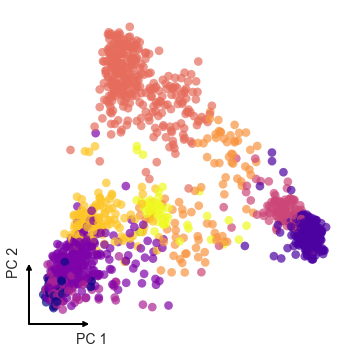

In [6]:
DR_plot(dim_name='PC').plot_IDs(retina, use_rep='pca2', obs_col='cluster')

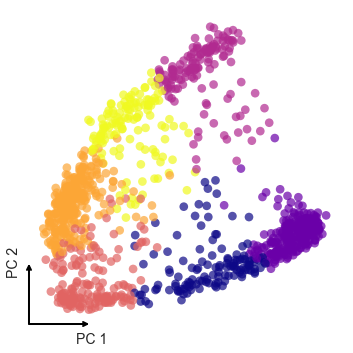

In [7]:
DR_plot(dim_name='PC').plot_IDs(colon, use_rep='pca2', obs_col='cluster')

---
### Compare MST topology

In [8]:
find_centroids(retina, use_rep='X', obs_col='cluster')
find_centroids(retina, use_rep='pca2', obs_col='cluster')
find_centroids(retina, use_rep='tsne', obs_col='cluster')
find_centroids(retina, use_rep='umap', obs_col='cluster')
find_centroids(retina, use_rep='dca', obs_col='cluster')
find_centroids(retina, use_rep='fitsne', obs_col='cluster')
find_centroids(retina, use_rep='scvi_tsne', obs_col='cluster')
find_centroids(retina, use_rep='zifa', obs_col='cluster')
find_centroids(retina, use_rep='glmpca', obs_col='cluster')
find_centroids(retina, use_rep='simlr_ydata', obs_col='cluster')
find_centroids(retina, use_rep='zinbwave', obs_col='cluster')
find_centroids(retina, use_rep='pca10', obs_col='cluster')
find_centroids(retina, use_rep='scvis', obs_col='cluster')

In [9]:
permutations = {'retina':{}, 'colon':{}} # initialize dictionary for final edge permutation stats

2 permuted edges from native space.


/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


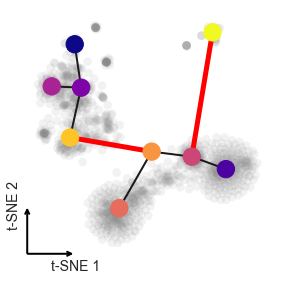

In [10]:
tsne_set = set(retina.uns['tsne_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(tsne_set)))
permutations['retina']['t-SNE'] = len(tsne_set)
DR_plot(dim_name='t-SNE', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster', use_rep='tsne', highlight_edges=tsne_set)

1 permuted edges from native space.


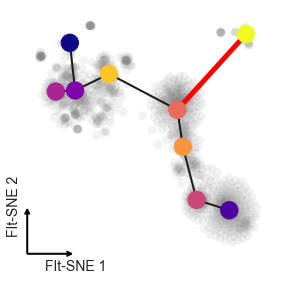

In [11]:
fitsne_set = set(retina.uns['fitsne_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(fitsne_set)))
permutations['retina']['FIt-SNE'] = len(fitsne_set)
DR_plot(dim_name='FIt-SNE', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster', use_rep='fitsne', highlight_edges=fitsne_set)

2 permuted edges from native space.


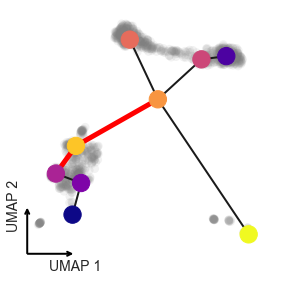

In [12]:
umap_set = set(retina.uns['umap_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(umap_set)))
permutations['retina']['UMAP'] = len(umap_set)
DR_plot(dim_name='UMAP', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster', use_rep='umap', highlight_edges=umap_set)

3 permuted edges from native space.


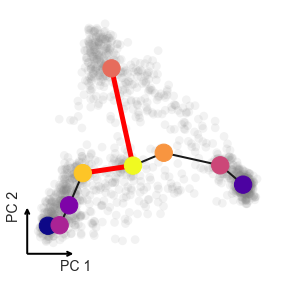

In [13]:
pca2_set = set(retina.uns['pca2_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(pca2_set)))
permutations['retina']['PCA (2)'] = len(pca2_set)
DR_plot(dim_name='PC', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster', use_rep='pca2', highlight_edges=pca2_set)

3 permuted edges from native space.


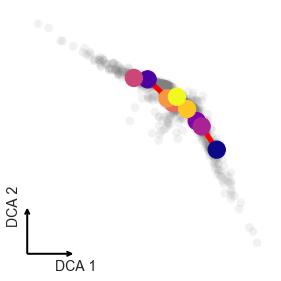

In [14]:
dca_set = set(retina.uns['dca_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(dca_set)))
permutations['retina']['DCA'] = len(dca_set)
DR_plot(dim_name='DCA', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster', use_rep='dca', highlight_edges=dca_set)

4 permuted edges from native space.


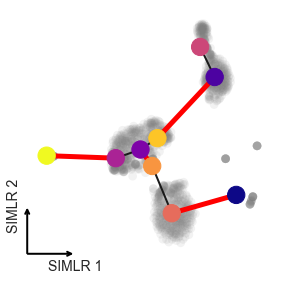

In [15]:
simlr_set = set(retina.uns['simlr_ydata_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(simlr_set)))
permutations['retina']['SIMLR'] = len(simlr_set)
DR_plot(dim_name='SIMLR', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster', use_rep='simlr_ydata', highlight_edges=simlr_set)

2 permuted edges from native space.


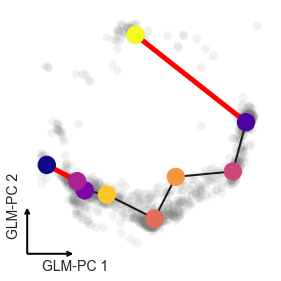

In [16]:
glmpca_set = set(retina.uns['glmpca_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(glmpca_set)))
permutations['retina']['GLM-PCA'] = len(glmpca_set)
DR_plot(dim_name='GLM-PC', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster', use_rep='glmpca', highlight_edges=glmpca_set)

3 permuted edges from native space.


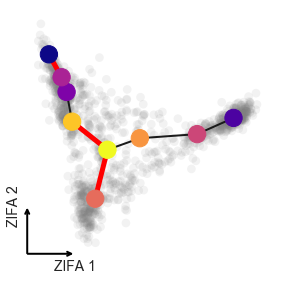

In [17]:
zifa_set = set(retina.uns['zifa_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(zifa_set)))
permutations['retina']['ZIFA'] = len(zifa_set)
DR_plot(dim_name='ZIFA', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster', use_rep='zifa', highlight_edges=zifa_set)

3 permuted edges from native space.


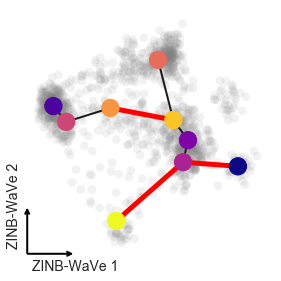

In [18]:
zinbwave_set = set(retina.uns['zinbwave_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(zinbwave_set)))
permutations['retina']['ZINB-WaVe'] = len(zinbwave_set)
DR_plot(dim_name='ZINB-WaVe', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster', use_rep='zinbwave', highlight_edges=zinbwave_set)

1 permuted edges from native space.


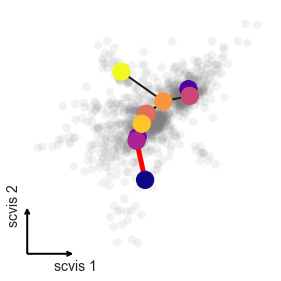

In [19]:
scvis_set = set(retina.uns['scvis_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(scvis_set)))
permutations['retina']['scvis'] = len(scvis_set)
DR_plot(dim_name='scvis', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster', use_rep='scvis', highlight_edges=scvis_set)

0 permuted edges from native space.


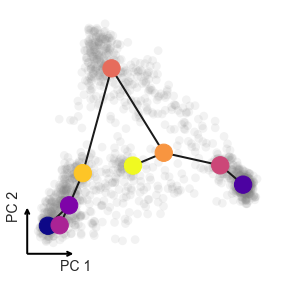

In [20]:
pca10_set = set(retina.uns['pca10_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(pca10_set)))
permutations['retina']['PCA (10)'] = len(pca10_set)
DR_plot(dim_name='PC', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster', use_rep='pca10', highlight_edges=pca10_set)

4 permuted edges from native space.


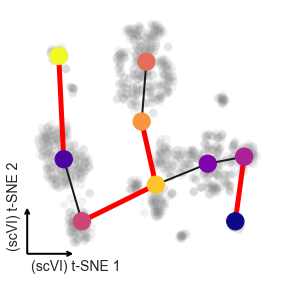

In [21]:
scvi_set = set(retina.uns['scvi_tsne_centroid_MST'].edges).difference(set(retina.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(scvi_set)))
permutations['retina']['scVI t-SNE'] = len(scvi_set)
DR_plot(dim_name='(scVI) t-SNE', figsize=(4,4)).plot_centroids(adata=retina, obs_col='cluster', use_rep='scvi_tsne', highlight_edges=scvi_set)

---
### Compare MST topology

In [22]:
find_centroids(colon, use_rep='X', obs_col='cluster')
find_centroids(colon, use_rep='pca2', obs_col='cluster')
find_centroids(colon, use_rep='tsne', obs_col='cluster')
find_centroids(colon, use_rep='umap', obs_col='cluster')
find_centroids(colon, use_rep='dca', obs_col='cluster')
find_centroids(colon, use_rep='fitsne', obs_col='cluster')
find_centroids(colon, use_rep='scvi_tsne', obs_col='cluster')
find_centroids(colon, use_rep='zifa', obs_col='cluster')
find_centroids(colon, use_rep='glmpca', obs_col='cluster')
find_centroids(colon, use_rep='simlr_ydata', obs_col='cluster')
find_centroids(colon, use_rep='zinbwave', obs_col='cluster')
find_centroids(colon, use_rep='pca10', obs_col='cluster')
find_centroids(colon, use_rep='scvis', obs_col='cluster')

0 permuted edges from native space.


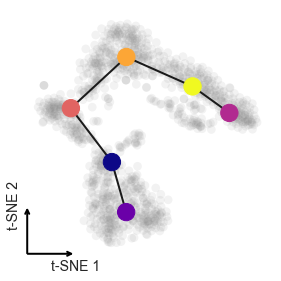

In [23]:
tsne_set = set(colon.uns['tsne_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(tsne_set)))
permutations['colon']['t-SNE'] = len(tsne_set)
DR_plot(dim_name='t-SNE', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster', use_rep='tsne', highlight_edges=tsne_set)

0 permuted edges from native space.


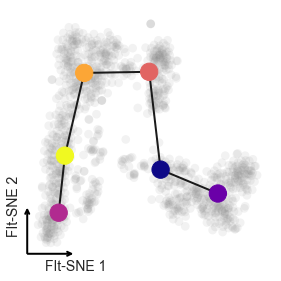

In [24]:
fitsne_set = set(colon.uns['fitsne_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(fitsne_set)))
permutations['colon']['FIt-SNE'] = len(fitsne_set)
DR_plot(dim_name='FIt-SNE', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster', use_rep='fitsne', highlight_edges=fitsne_set)

0 permuted edges from native space.


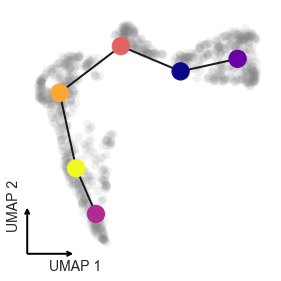

In [25]:
umap_set = set(colon.uns['umap_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(umap_set)))
permutations['colon']['UMAP'] = len(umap_set)
DR_plot(dim_name='UMAP', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster', use_rep='umap', highlight_edges=umap_set)

0 permuted edges from native space.


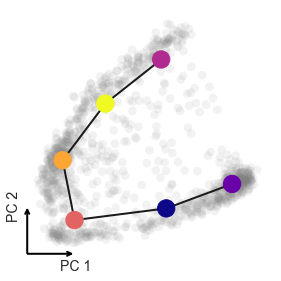

In [26]:
pca2_set = set(colon.uns['pca2_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(pca2_set)))
permutations['colon']['PCA (2)'] = len(pca2_set)
DR_plot(dim_name='PC', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster', use_rep='pca2', highlight_edges=pca2_set)

0 permuted edges from native space.


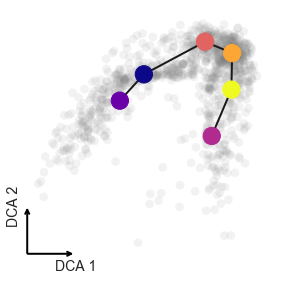

In [27]:
dca_set = set(colon.uns['dca_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(dca_set)))
permutations['colon']['DCA'] = len(dca_set)
DR_plot(dim_name='DCA', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster', use_rep='dca', highlight_edges=dca_set)

0 permuted edges from native space.


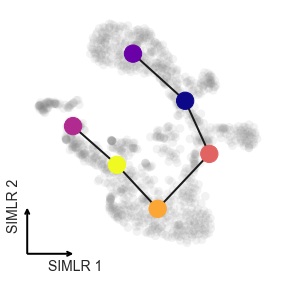

In [28]:
simlr_set = set(colon.uns['simlr_ydata_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(simlr_set)))
permutations['colon']['SIMLR'] = len(simlr_set)
DR_plot(dim_name='SIMLR', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster', use_rep='simlr_ydata', highlight_edges=simlr_set)

0 permuted edges from native space.


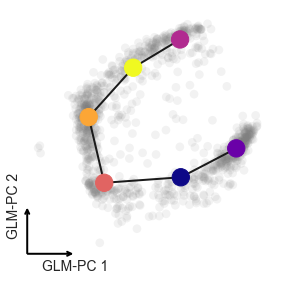

In [29]:
glmpca_set = set(colon.uns['glmpca_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(glmpca_set)))
permutations['colon']['GLM-PCA'] = len(glmpca_set)
DR_plot(dim_name='GLM-PC', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster', use_rep='glmpca', highlight_edges=glmpca_set)

0 permuted edges from native space.


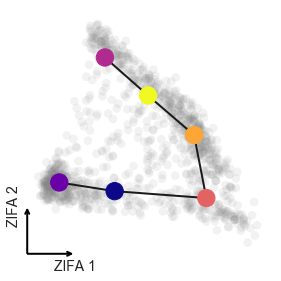

In [30]:
zifa_set = set(colon.uns['zifa_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(zifa_set)))
permutations['colon']['ZIFA'] = len(zifa_set)
DR_plot(dim_name='ZIFA', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster', use_rep='zifa', highlight_edges=zifa_set)

0 permuted edges from native space.


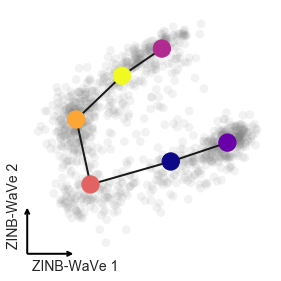

In [31]:
zinbwave_set = set(colon.uns['zinbwave_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(zinbwave_set)))
permutations['colon']['ZINB-WaVe'] = len(zinbwave_set)
DR_plot(dim_name='ZINB-WaVe', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster', use_rep='zinbwave', highlight_edges=zinbwave_set)

0 permuted edges from native space.


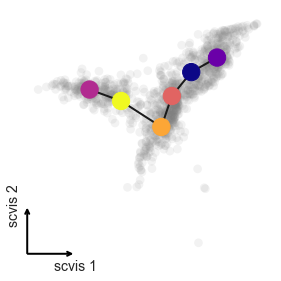

In [32]:
scvis_set = set(colon.uns['scvis_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(scvis_set)))
permutations['colon']['scvis'] = len(scvis_set)
DR_plot(dim_name='scvis', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster', use_rep='scvis', highlight_edges=scvis_set)

0 permuted edges from native space.


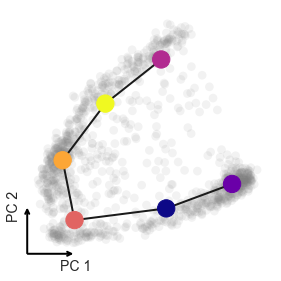

In [33]:
pca10_set = set(colon.uns['pca10_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(pca10_set)))
permutations['colon']['PCA (10)'] = len(pca10_set)
DR_plot(dim_name='PC', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster', use_rep='pca10', highlight_edges=pca10_set)

0 permuted edges from native space.


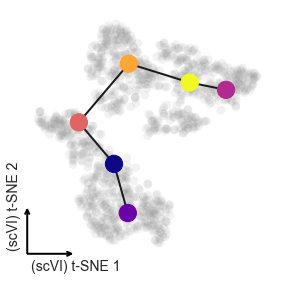

In [34]:
scvi_set = set(colon.uns['scvi_tsne_centroid_MST'].edges).difference(set(colon.uns['X_centroid_MST'].edges))
print('{} permuted edges from native space.'.format(len(scvi_set)))
permutations['colon']['scVI t-SNE'] = len(scvi_set)
DR_plot(dim_name='(scVI) t-SNE', figsize=(4,4)).plot_centroids(adata=colon, obs_col='cluster', use_rep='scvi_tsne', highlight_edges=scvi_set)

---

In [35]:
ret = pd.DataFrame(permutations['retina'], index=['Retina'])
col = pd.DataFrame(permutations['colon'], index=['Colon'])
final = pd.concat([ret, col])
final = final.T.sort_values('Retina', ascending=False)

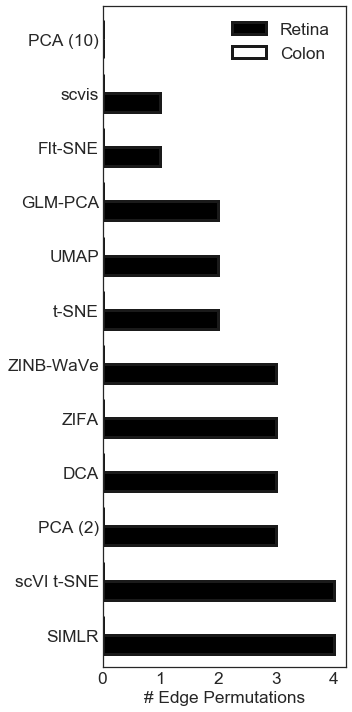

In [36]:
with plt.style.context('seaborn-white'):
    final.plot(kind='barh', width=0.7, figsize=(5,10), color=['black','white'], ec='k', linewidth=3)
    plt.xlabel('# Edge Permutations', fontsize='xx-large')
    plt.yticks(range(0,12), fontsize='xx-large')
    plt.xticks([0,1,2,3,4], fontsize='xx-large')
    plt.legend(fontsize='xx-large')
    plt.tight_layout()
    plt.show()